<a href="https://colab.research.google.com/github/macontreras04/cpf/blob/main/assetman_practprojec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miguel Contreras, August 14th 2024


# **Portfolio Optimization and Backtesting Using Mean-Variance Approach**

This notebook details the implementation and analysis of a portfolio optimization strategy using the Mean-Variance Portfolio (MVP) model. The strategy is tested using historical financial data from various assets to determine optimal asset allocation and evaluate performance via a rolling backtest approach.

## 1. Data Preprocessing

The dataset comprises daily closing prices for various financial indices, which undergo several preprocessing steps.

### Importing Libraries and Loading Data




In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load and preprocess the data
url = 'https://hilpisch.com/indices_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True)

# Fill missing values using forward fill method and drop any remaining NaNs
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# Calculate returns
returns = data.pct_change().dropna()


<ipython-input-15-72ee53946625>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


### Calculating Arithmetic Returns

The returns are calculated as arithmetic returns, which are straightforward to interpret and commonly used in financial analysis. The formula for arithmetic returns is given by:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

In [ ]:
print(returns)

               .FCHI     .FTSE    .GDAXI      .HSI      .NDX     .NSEI  \
Date                                                                     
2016-01-05  0.003357  0.007190  0.002593 -0.006489 -0.003041 -0.000854   
2016-01-06 -0.012597 -0.010405 -0.009319 -0.009812 -0.008964 -0.005607   
2016-01-07 -0.017161 -0.019643 -0.022926 -0.030860 -0.031112 -0.022310   
2016-01-08 -0.015855 -0.006994 -0.013077  0.005920 -0.008115  0.004367   
2016-01-11 -0.004850 -0.006869 -0.002464 -0.027634  0.002989 -0.004933   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.001009  0.000979  0.000000  0.001650  0.004574  0.010893   
2020-12-28  0.012019  0.000000  0.014945 -0.002726  0.010058  0.009015   
2020-12-29  0.004189  0.015463 -0.002096  0.009647  0.000361  0.004282   
2020-12-30 -0.002206 -0.007093 -0.003096  0.021778  0.000145  0.003542   
2020-12-31 -0.008572 -0.014537  0.000000  0.003095  0.003342 -0.000014   

                .SPX     .SSEC  
Date

## 2. Mean-Variance Portfolio (MVP) Model

The MVP model seeks to construct an optimal portfolio by minimizing variance (risk) or maximizing the Sharpe ratio, defined as the excess return per unit of risk.

### Portfolio Expected Return and Variance

For a portfolio with \( n \) assets, the expected return \( \mu_p \) and variance \( \sigma_p^2 \) are calculated as:

$$
\mu_p = \sum_{i=1}^{n} w_i \mu_i = \mathbf{w}^\top \mathbf{\mu}
$$

$$
\sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w} = \sum_{i=1}^{n}\sum_{j=1}^{n} w_i w_j \sigma_{ij}
$$

In [ ]:
class MeanVariancePortfolio:
    def __init__(self, returns):
        self.returns = returns
        self.mean_returns = returns.mean()
        self.cov_matrix = returns.cov()

    def portfolio_performance(self, weights):
        returns = np.dot(weights, self.mean_returns)
        std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        return returns, std

    def minimize_variance(self):
        num_assets = len(self.mean_returns)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for asset in range(num_assets))
        result = minimize(self.portfolio_variance, num_assets * [1. / num_assets,],
                          method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

    def portfolio_variance(self, weights):
        return self.portfolio_performance(weights)[1]**2

    def maximize_sharpe_ratio(self, risk_free_rate=0.0):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix, risk_free_rate)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for asset in range(num_assets))
        result = minimize(self.neg_sharpe_ratio, num_assets * [1. / num_assets,],
                          args=args, method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

    def neg_sharpe_ratio(self, weights, mean_returns, cov_matrix, risk_free_rate=0.0):
        p_ret = np.dot(weights, mean_returns)
        p_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - (p_ret - risk_free_rate) / p_std


### Efficient Frontier

The efficient frontier is a graphical representation of the optimal portfolios that offer the highest expected return for a defined level of risk. Below is the code to generate and plot the efficient frontier.


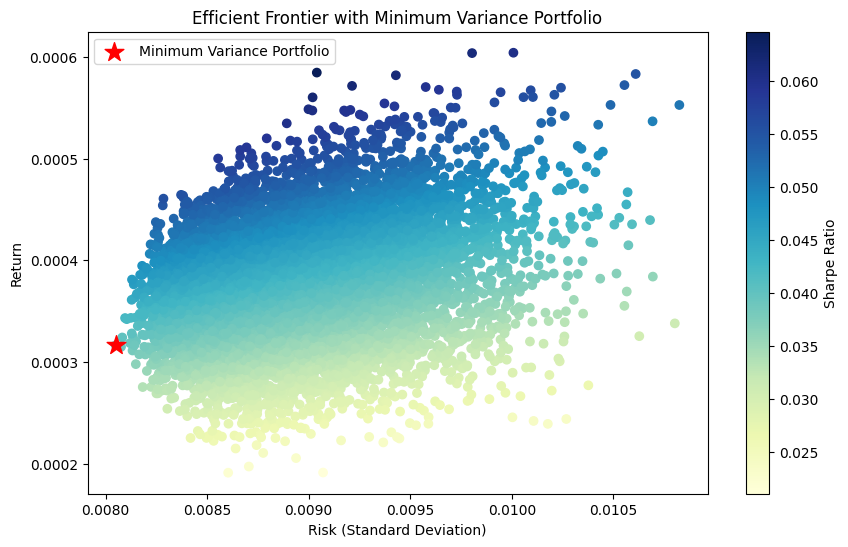

In [ ]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.0):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        returns, std = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (returns - risk_free_rate) / std

        results[0,i] = std
        results[1,i] = returns
        results[2,i] = sharpe_ratio
        weights_record.append(weights)

    # Find the portfolio with the minimum variance
    min_variance_idx = np.argmin(results[0])
    min_variance_std, min_variance_return = results[0,min_variance_idx], results[1,min_variance_idx]
    min_variance_weights = weights_record[min_variance_idx]

    plt.figure(figsize=(10, 6))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(min_variance_std, min_variance_return, color='red', marker='*', s=200, label='Minimum Variance Portfolio')
    plt.title('Efficient Frontier with Minimum Variance Portfolio')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend(labelspacing=0.8)
    plt.show()

    return min_variance_weights

# Calculate mean returns and covariance matrix from the full dataset
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Plot the Efficient Frontier and get the Minimum Variance Portfolio weights
min_variance_weights = plot_efficient_frontier(mean_returns, cov_matrix)


## 3. Rolling Backtest

A rolling backtest is implemented to simulate the performance of the optimized portfolio over time. The backtest uses a rolling window of 252 trading days (approximately one year) to re-estimate the portfolio weights and evaluate the out-of-sample performance.

### Rolling Backtest Implementation


In [ ]:
# Rolling Backtest Class
class RollingBacktest(MeanVariancePortfolio):
    def __init__(self, returns, lookback_period=252):
        super().__init__(returns)
        self.lookback_period = lookback_period
        self.out_of_sample_returns = []

    def run_backtest(self):
        num_periods = len(self.returns) - self.lookback_period

        for i in range(num_periods):
            train_data = self.returns.iloc[i:i+self.lookback_period]
            test_data = self.returns.iloc[i+self.lookback_period]

            # Recalculate mean returns and covariance matrix for the current window
            self.mean_returns = train_data.mean()
            self.cov_matrix = train_data.cov()

            # Optimize the portfolio
            weights = self.maximize_sharpe_ratio()

            # Calculate out-of-sample return
            out_of_sample_return = np.dot(test_data, weights)
            self.out_of_sample_returns.append(out_of_sample_return)

        return np.array(self.out_of_sample_returns)

    def calculate_annualized_return(self):
        return np.mean(self.out_of_sample_returns) * 52

    def total_performance(self):
        return np.cumprod(1 + np.array(self.out_of_sample_returns))[-1] - 1

# Instantiate the backtest class with a 1-year (252 trading days) lookback period
backtest = RollingBacktest(returns, lookback_period=252)

# Run the backtest
out_of_sample_returns = backtest.run_backtest()

# Calculate annualized return and total performance
annualized_return = backtest.calculate_annualized_return()
total_performance = backtest.total_performance()

print(f"Annualized Return: {annualized_return}")
print(f"Total Performance: {total_performance}")



Annualized Return: 0.02277213629363569
Total Performance: 0.4499449955070072


### Cumulative Returns Plot

The cumulative returns plot shows the growth of $1 invested in the portfolio over the backtest period.


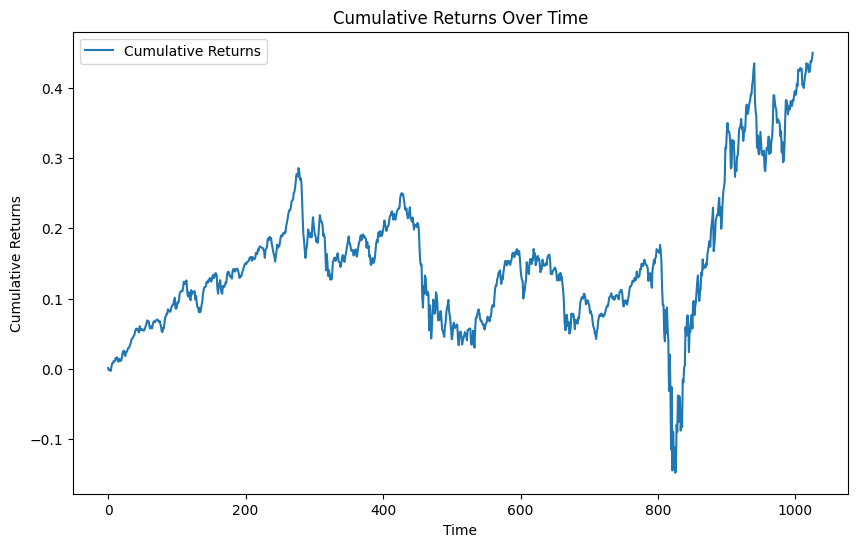

In [ ]:
def plot_cumulative_returns(out_of_sample_returns):
    cumulative_returns = np.cumprod(1 + out_of_sample_returns) - 1
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Cumulative Returns')
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

plot_cumulative_returns(out_of_sample_returns)


### Rolling Sharpe Ratio

The rolling Sharpe ratio is calculated using a 52-week window, providing insights into how the portfolio's risk-adjusted performance evolves over time.


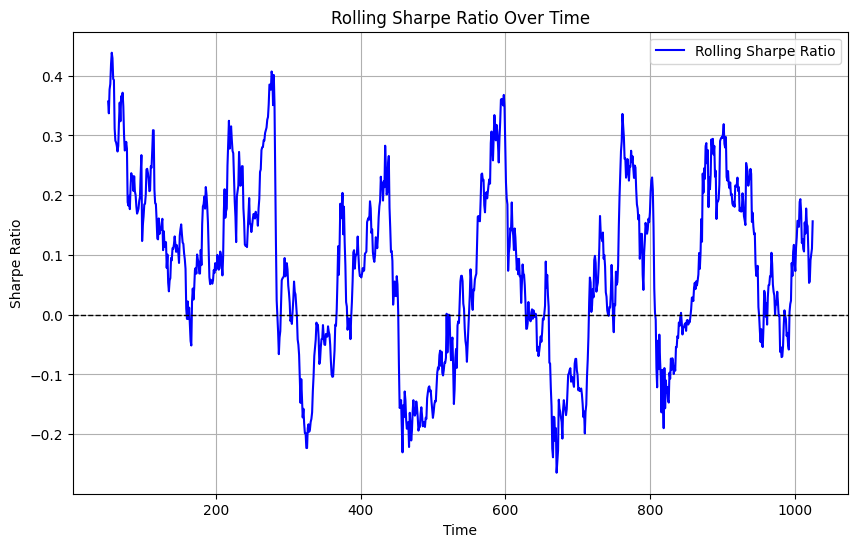

In [ ]:
def plot_rolling_sharpe_ratio(out_of_sample_returns, window=52, risk_free_rate=0.0):
    returns_series = pd.Series(out_of_sample_returns)
    rolling_mean = returns_series.rolling(window=window).mean()
    rolling_std = returns_series.rolling(window=window).std()
    rolling_sharpe_ratio = (rolling_mean - risk_free_rate) / rolling_std

    plt.figure(figsize=(10, 6))
    plt.plot(rolling_sharpe_ratio, label='Rolling Sharpe Ratio', color='blue')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title('Rolling Sharpe Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_sharpe_ratio(out_of_sample_returns, window=52, risk_free_rate=0.0)


# One-Page Report: Experience with Mean-Variance Portfolio Project

**Name:** Miguel  
**Date:** August 14, 2024

---

## Understanding of Central Topics and Tools

During this project, I have deepened my understanding of several key topics in financial analysis and portfolio management, particularly:

1. **Mean-Variance Portfolio (MVP) Model:**
   - The MVP model is a foundational concept in modern portfolio theory, focusing on optimizing a portfolio by balancing return and risk through variance minimization and Sharpe ratio maximization.
   - Understanding how to construct an optimal portfolio using historical data, calculating expected returns, covariance matrices, and efficiently solving optimization problems.

2. **Rolling Backtest:**
   - Implementing a rolling backtest approach provided insights into how portfolios perform in an out-of-sample context, simulating real-world conditions where portfolio weights are periodically recalculated based on recent data.

3. **Tools:**
   - **Python Libraries:** Utilizing `pandas` for data manipulation, `numpy` for numerical computations, and `scipy.optimize` for solving optimization problems.
   - **Matplotlib:** Creating visualizations such as the efficient frontier, cumulative returns, and rolling Sharpe ratio, which are essential for interpreting portfolio performance.

## Strengths and Weaknesses

### **Strengths:**

- **Data Handling:** I feel confident in my ability to preprocess financial data, handle missing values, and compute returns, which are crucial steps in any financial analysis project.
- **Mathematical Understanding:** My grasp of the mathematical concepts underlying portfolio optimization, such as covariance matrices and optimization techniques, has improved significantly.
- **Coding Skills:** Implementing the MVP model and backtest from scratch enhanced my proficiency in Python, particularly in using libraries like `scipy` for optimization and `matplotlib` for visualization.

### **Weaknesses:**

- **Time Management:** Balancing the time spent on coding versus understanding theoretical concepts was challenging, and I found myself spending more time than anticipated on debugging and code optimization.

## Experiences Doing It On My Own

Working independently on this project was both challenging and rewarding. The process required a balance between theoretical understanding and practical application, which I found particularly engaging. The hands-on experience of coding from scratch without relying on existing implementations forced me to think critically about each step and solidified my understanding of the concepts.

However, working alone also meant facing challenges in problem-solving without immediate feedback or collaboration. This experience highlighted the importance of self-motivation and resourcefulness, as I had to rely on documentation, online resources, and my own troubleshooting skills to overcome obstacles.

## Conclusion

This project demonstrates the application of the Mean-Variance Portfolio model for optimizing asset allocation and evaluating portfolio performance through a mathematically rigorous framework. The rolling backtest offers insights into how the portfolio performs under changing market conditions. The use of quadratic and nonlinear optimization techniques provides a robust methodology for constructing portfolios with desirable risk-return profiles.

Further extensions could involve integrating transaction costs, exploring more sophisticated risk models such as Conditional Value-at-Risk (CVaR), or applying the framework to different asset classes such as bonds or commodities.

## Opportunities to Improve the Existing Materials and Resources

1. **Expanded Examples:** Including more examples of different types of portfolios (e.g., fixed income, multi-asset) in the learning materials could provide a broader perspective and practical application of the MVP model.
2. **Step-by-Step Guides:** A more detailed, step-by-step guide on implementing rolling backtests, including common pitfalls and debugging tips, would be beneficial for those new to these concepts.
3. **Interactive Elements:** Incorporating interactive elements or exercises in the learning resources could enhance understanding by allowing users to experiment with different parameters and immediately see the effects on portfolio performance.

## Other Comments

Overall, this project was a valuable learning experience that not only strengthened my technical skills but also deepened my understanding of key financial concepts. The combination of theory and practical coding was particularly effective in solidifying my knowledge. I look forward to continuing to build on this foundation and explore more advanced topics in the future.